In [1]:
import numpy as np
import pandas as pd
import sqlite3
from sqlite3 import Error
import matplotlib.pyplot as plt
import seaborn as sns

import imblearn

from imblearn.over_sampling import SMOTE


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
### download the db from link in readme
db_path = "../../dbs/delays.db"

In [3]:
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        connection.text_factory = str
    except Error as e:
        print("Error occurred: " + str(e))
    return connection


def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        if query == "":
            return "Query Blank"
        else:
            df = pd.read_sql_query(query, connection)
            return df
    except Error as e:
        return "Error occurred: " + str(e)

In [4]:
def onehot_encode(df, column_dict):
    df = df.copy()
    for column, prefix in column_dict.items():
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

In [5]:
def preprocess_inputs(df):
    df = df.copy()
    
    y = (df.ArrDelay>30).astype(int)
    
    
    df = df[['Year',
     'Month',
     'DayofMonth',
     'DayOfWeek',
     'IATA_CODE_Reporting_Airline',
     'OriginAirportID',
     'DestAirportID',
     'AirTime',
     'Distance',
    ]]
    

    
    # One-hot encode nominal feature columns
    X = onehot_encode(
        df,
        column_dict={
            'IATA_CODE_Reporting_Airline': 'AL',
            'OriginAirportID': 'OA',
            'DestAirportID': 'DA',
            'Year': 'Y',
            'Month': 'M',
            'DayofMonth': 'DM',
            'DayOfWeek': 'DW'
        }
    )
    
    
    smote = SMOTE()
    X, y = smote.fit_resample(X, y)

    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
    
    
    # Scale X with a standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
   
    return X_train, X_test, y_train, y_test

In [6]:
def evaluate_model(model, X_test, y_test):
    
    model_acc = model.score(X_test, y_test)
    print("Test Accuracy: {:.2f}%".format(model_acc * 100))
    
    y_true = np.array(y_test)
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_true, y_pred)
    clr = classification_report(y_true, y_pred, target_names=["Not Delayed", "Delayed"])
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(2) + 0.5, ["Not Delayed", "Delayed"])
    plt.yticks(np.arange(2) + 0.5, ["Not Delayed", "Delayed"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

In [7]:
sample_query = \
    """
        select 
         *
        from 
          delay 
        where year = 2018
        order by RANDOM() LIMIT 100000
    """

connection = create_connection(db_path)
data =  execute_query(connection, sample_query)

In [8]:
data

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,...,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2018,2,4,21,6,2018-04-21,19977,UA,N35271,1983,...,173,167,151,1,1068,0,0,0,0,0
1,2018,3,9,20,4,2018-09-20,19790,DL,N976DL,1801,...,85,75,50,1,306,0,0,0,0,0
2,2018,1,2,12,1,2018-02-12,20378,YV,N521LR,6212,...,68,66,50,1,224,0,0,0,0,0
3,2018,3,9,15,6,2018-09-15,20304,OO,N823SK,3621,...,135,120,99,1,695,0,0,0,0,0
4,2018,4,12,3,1,2018-12-03,20366,EV,N22909,4053,...,100,92,76,1,427,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2018,1,1,13,6,2018-01-13,19805,AA,N130AN,2480,...,211,186,165,1,1235,0,0,0,0,0
99996,2018,4,12,31,1,2018-12-31,20304,OO,N759EV,3171,...,136,0,0,1,651,0,0,0,0,0
99997,2018,3,9,22,6,2018-09-22,20452,YX,N136HQ,4596,...,182,160,138,1,972,0,0,0,0,0
99998,2018,2,6,27,3,2018-06-27,19393,WN,N8651A,1155,...,195,189,178,1,1342,0,0,0,0,0


In [9]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [10]:
X_train

,AirTime,Distance,AL_9E,AL_AA,AL_AS,AL_B6,AL_DL,AL_EV,AL_F9,AL_G4,...,DM_29,DM_30,DM_31,DW_1,DW_2,DW_3,DW_4,DW_5,DW_6,DW_7
0,-0.892816,-0.747159,-0.15538,-0.328593,-0.158355,-0.179964,-0.319476,-0.140891,-0.110251,-0.089604,...,-0.132993,-0.136691,-0.107197,-0.334684,-0.328129,-0.327216,-0.334186,-0.34075,-0.287756,-0.318450
1,0.062016,0.056861,-0.15538,-0.328593,-0.158355,-0.179964,-0.319476,-0.140891,-0.110251,-0.089604,...,-0.132993,-0.136691,-0.107197,-0.334684,-0.328129,-0.327216,2.992350,-0.34075,-0.287756,-0.318450
2,-0.691091,-0.692376,-0.15538,-0.328593,-0.158355,-0.179964,-0.319476,-0.140891,-0.110251,-0.089604,...,-0.132993,-0.136691,-0.107197,-0.334684,-0.328129,3.056086,-0.334186,-0.34075,-0.287756,-0.318450
3,1.877540,1.461883,-0.15538,3.043283,-0.158355,-0.179964,-0.319476,-0.140891,-0.110251,-0.089604,...,-0.132993,-0.136691,-0.107197,-0.334684,3.047577,-0.327216,-0.334186,-0.34075,-0.287756,-0.318450
4,-0.126261,-0.112322,-0.15538,-0.328593,-0.158355,-0.179964,-0.319476,-0.140891,-0.110251,-0.089604,...,-0.132993,-0.136691,-0.107197,-0.334684,-0.328129,-0.327216,-0.334186,-0.34075,-0.287756,3.140214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137223,-1.013851,-1.059745,-0.15538,-0.328593,-0.158355,-0.179964,-0.319476,-0.140891,-0.110251,-0.089604,...,-0.132993,-0.136691,-0.107197,-0.334684,-0.328129,-0.327216,-0.334186,-0.34075,-0.287756,-0.318450
137224,-0.825574,-0.911508,-0.15538,-0.328593,-0.158355,-0.179964,-0.319476,-0.140891,-0.110251,-0.089604,...,-0.132993,-0.136691,-0.107197,-0.334684,-0.328129,-0.327216,-0.334186,-0.34075,-0.287756,-0.318450
137225,-0.543159,-0.547363,-0.15538,-0.328593,-0.158355,-0.179964,-0.319476,-0.140891,-0.110251,-0.089604,...,-0.132993,-0.136691,-0.107197,-0.334684,-0.328129,-0.327216,-0.334186,-0.34075,-0.287756,-0.318450
137226,-0.462469,-0.354011,-0.15538,-0.328593,-0.158355,-0.179964,-0.319476,-0.140891,-0.110251,-0.089604,...,-0.132993,-0.136691,-0.107197,-0.334684,-0.328129,-0.327216,-0.334186,-0.34075,-0.287756,-0.318450


In [11]:
clf_rf = RandomForestClassifier(n_estimators = 100) 
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf_rf.fit(X_train, y_train)
 

RandomForestClassifier()

Test Accuracy: 91.54%


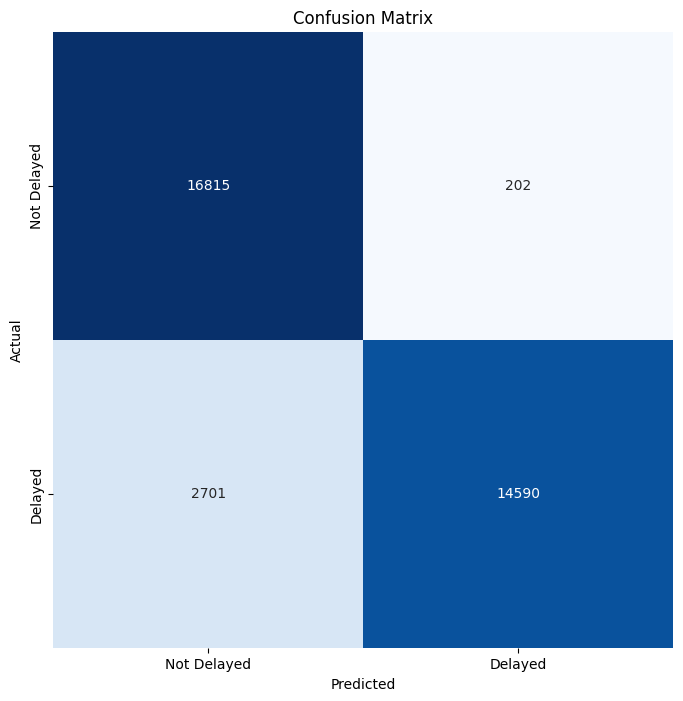

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.86      0.99      0.92     17017
     Delayed       0.99      0.84      0.91     17291

    accuracy                           0.92     34308
   macro avg       0.92      0.92      0.92     34308
weighted avg       0.92      0.92      0.91     34308



In [12]:
evaluate_model(clf_rf, X_test, y_test)